# Behaviour Analysis

Dataset: Neurons (Steinmetz)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from app.dataset.steinmetz import load_data
from app.explore.summary import session_accuracy_report, session_accuracy, get_mouse_sessions
from app.utils.util import filter_trials

%matplotlib inline
sns.set_style("darkgrid")

## Load Data

`all_data` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = all_data[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  

In [2]:
all_data = load_data(data_path="./data/")

Loading data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Response Accuracy

### Response accuracy across sessions

Text(0.5, 1.0, 'Decision Accuracy Across Sessions')

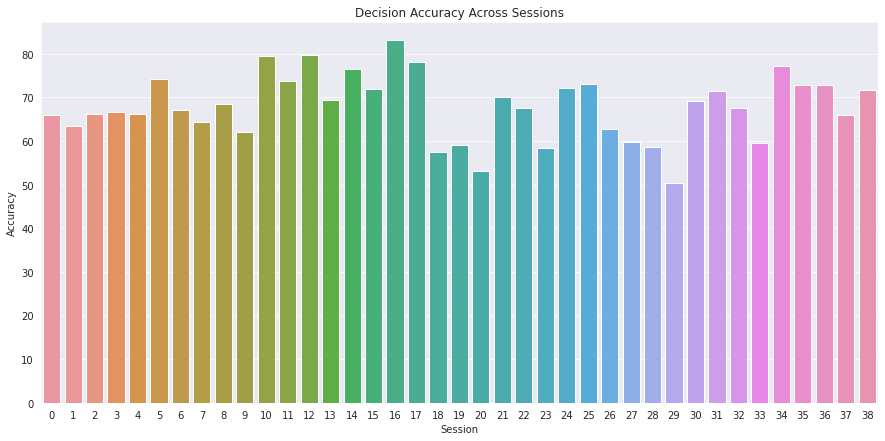

In [3]:
plt.figure(figsize=(15,7))
sns.barplot(x=np.arange(len(all_data)), 
            y = [session_accuracy(all_data, session_id=i) for i in range(len(all_data))]
           )
plt.xlabel("Session")
plt.ylabel("Accuracy")
plt.title("Decision Accuracy Across Sessions")

### Average response accuracy all sessions for the same mouse

In [4]:
single_mouse_session_ids = get_mouse_sessions(all_data=all_data, mouse_name="Lederberg")
single_mouse_session_ids

[11, 12, 13, 14, 15, 16, 17]

Text(0.5, 1.0, 'Response Accuracy Across Sessions')

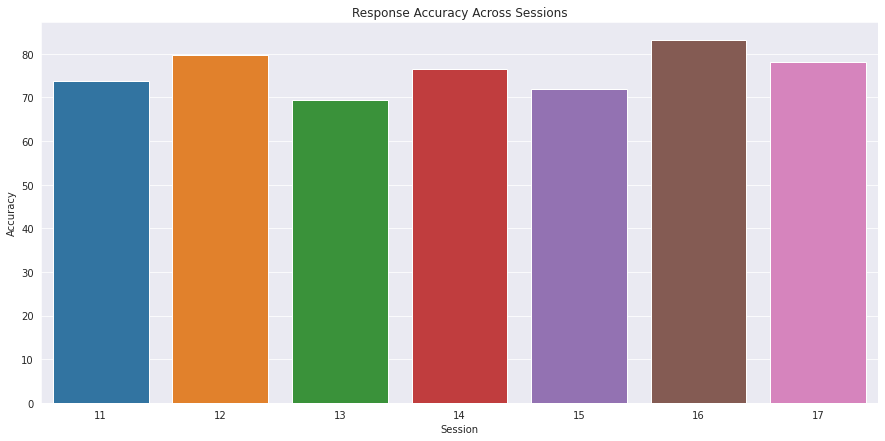

In [5]:
plt.figure(figsize=(15,7))
sns.barplot(x=single_mouse_session_ids, 
            y = [session_accuracy(all_data=all_data, session_id=i) for i in single_mouse_session_ids]
           )
plt.xlabel("Session")
plt.ylabel("Accuracy")
plt.title("Response Accuracy Across Sessions")

### Response accuracy across trials in a session for the same mosue

#### Cumulative accuracy

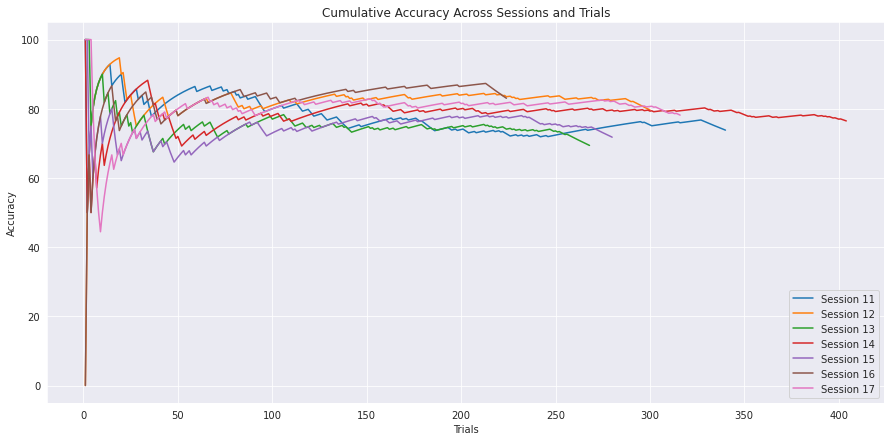

In [6]:
plt.figure(figsize=(15,7))

for i in range(len(single_mouse_session_ids)):
    session_id = single_mouse_session_ids[i]
    
    cumulative_acc = np.cumsum(np.where(all_data[session_id]["feedback_type"] == -1, 0, 1))/np.arange(1, len(all_data[session_id]["feedback_type"])+1)
    plt.plot(np.arange(1, len(all_data[session_id]["feedback_type"])+1), cumulative_acc*100, label=f"Session {session_id}")
    
    
plt.title("Cumulative Accuracy Across Sessions and Trials")
plt.xlabel("Trials")
plt.ylabel("Accuracy")
plt.legend()

#### Exponentially moving average accuracy

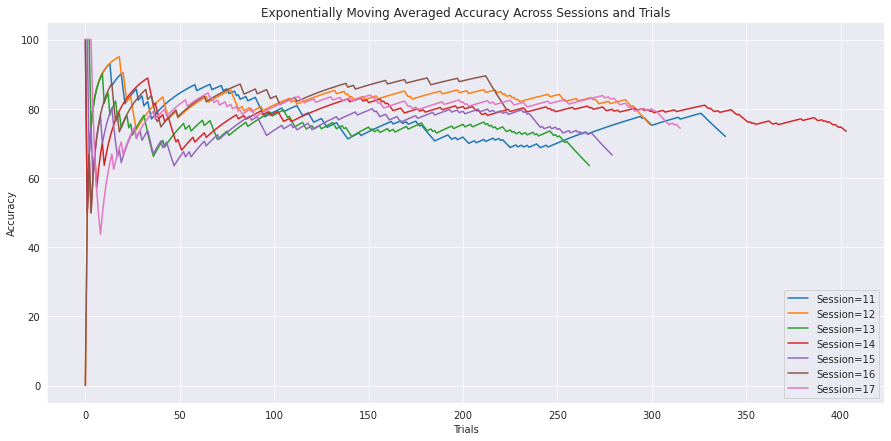

In [7]:
plt.figure(figsize=(15,7))

for i in range(len(single_mouse_session_ids)):
    session_id = single_mouse_session_ids[i]
    acc = pd.DataFrame(np.where(all_data[session_id]["feedback_type"] == -1, 0, 1))
    ewm_acc = acc.ewm(span=len(all_data[session_id]["feedback_type"])).mean()
    plt.plot(ewm_acc*100, label=f"Session={session_id}")
    
    
plt.title("Exponentially Moving Averaged Accuracy Across Sessions and Trials")
plt.xlabel("Trials")
plt.ylabel("Accuracy")
plt.legend()

#### Rolling window accuracy

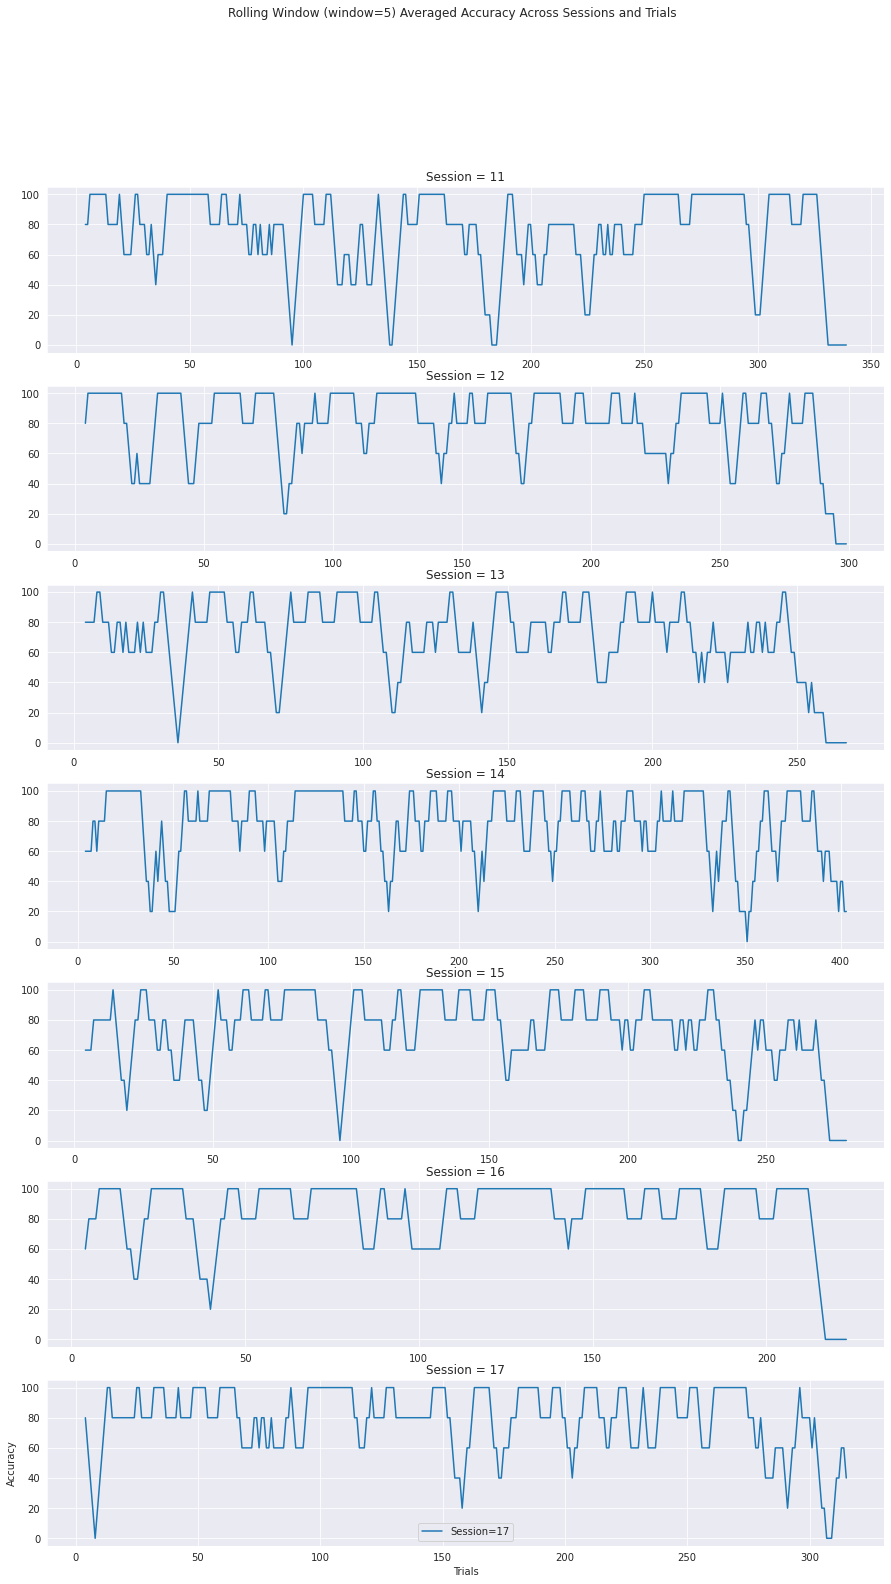

In [8]:
fig, axes = plt.subplots(nrows=len(single_mouse_session_ids), ncols=1, figsize=(15,25))
for i in range(len(single_mouse_session_ids)):
    session_id = single_mouse_session_ids[i]
    window_size = 5
    acc = pd.DataFrame(np.where(all_data[session_id]["feedback_type"] == -1, 0, 1)).rolling(window_size).mean()
    axes[i].plot(acc*100, label=f"Session={session_id}")
    axes[i].set_title(f"Session = {session_id}")
    
    
plt.suptitle(f"Rolling Window (window={window_size}) Averaged Accuracy Across Sessions and Trials")
plt.xlabel("Trials")
plt.ylabel("Accuracy")
plt.legend()

### Accuracy report for a single session

              precision    recall  f1-score   support

           0       0.78      0.40      0.53       126
           1       0.72      0.94      0.82       103
           2       0.63      0.80      0.71       111

    accuracy                           0.69       340
   macro avg       0.71      0.71      0.68       340
weighted avg       0.71      0.69      0.67       340



69.41176470588235

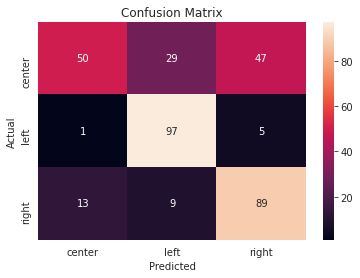

In [9]:
session_accuracy_report(all_data = all_data, session_id=11, plot=True)

## Filter Trials

### Filter trials by feedback

In [10]:
trials_feedback = filter_trials(all_data=all_data, session_id=11, filter_by="feedback")
for k,v in trials_feedback.items(): print(f"{k} = {v.shape}")

correct = (340,)
wrong = (340,)


### Filter trials by response

In [11]:
trials_response = filter_trials(all_data=all_data, session_id=11, filter_by="response")
for k,v in trials_response.items(): print(f"{k} = {v.shape}")

left = (340,)
middle = (340,)
right = (340,)


### Filter trials by response and feedback

In [12]:
trials_response_feedback = filter_trials(all_data=all_data, session_id=11, filter_by="response_feedback")
for k,v in trials_response_feedback.items(): print(f"{k} = {v.shape}")

left_correct = (340,)
left_wrong = (340,)
right_correct = (340,)
right_wrong = (340,)
middle_correct = (340,)
middle_wrong = (340,)


## Wheel Movement Speed

### Distribution of wheel speed in a session

Text(0, 0.5, 'Count')

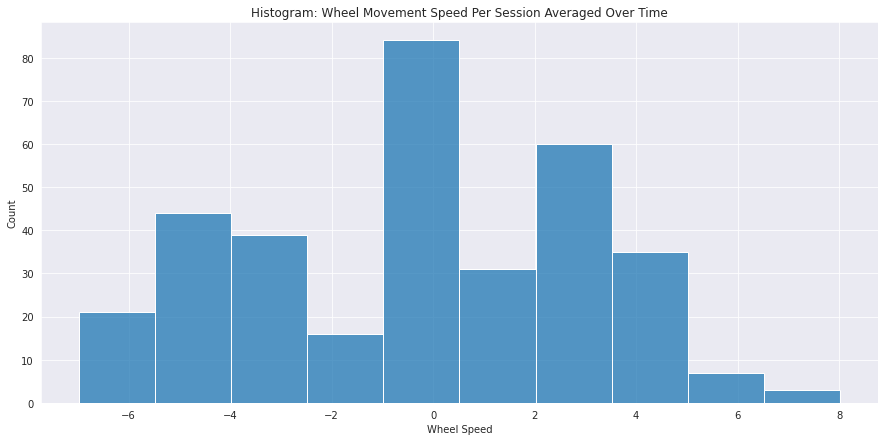

In [13]:
plt.figure(figsize=(15,7))
sns.histplot(all_data[11]["wheel"].mean(axis=1))
plt.title("Histogram: Wheel Movement Speed Per Session Averaged Over Time")
plt.xlabel("Wheel Speed")
plt.ylabel("Count")

### Wheel speed for a single trial

Text(0, 0.5, 'Wheel Speed')

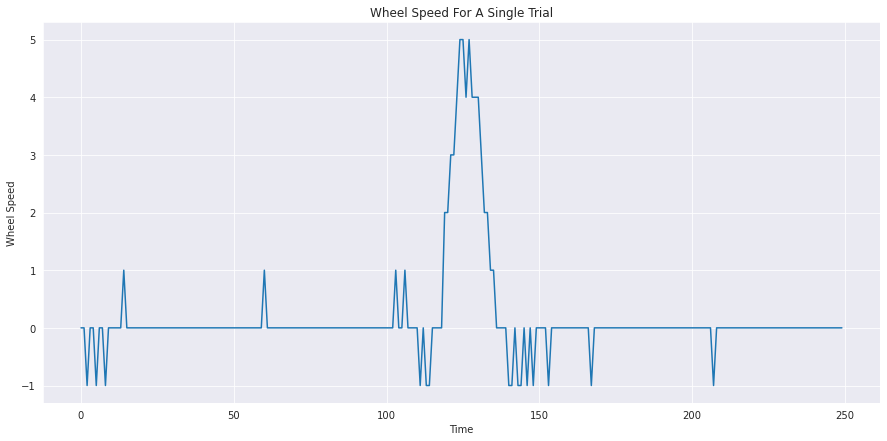

In [14]:
plt.figure(figsize=(15,7))
sns.lineplot(y = all_data[11]["wheel"][0, :], x = np.arange(250))
plt.title("Wheel Speed For A Single Trial")
plt.xlabel("Time")
plt.ylabel("Wheel Speed")

### Average wheel speed for correct and wrong trials

In [15]:
correct_trial_idx = filter_trials(all_data=all_data, session_id=11, filter_by="feedback")["correct"]
wrong_trial_idx = filter_trials(all_data=all_data, session_id=11, filter_by="feedback")["wrong"]

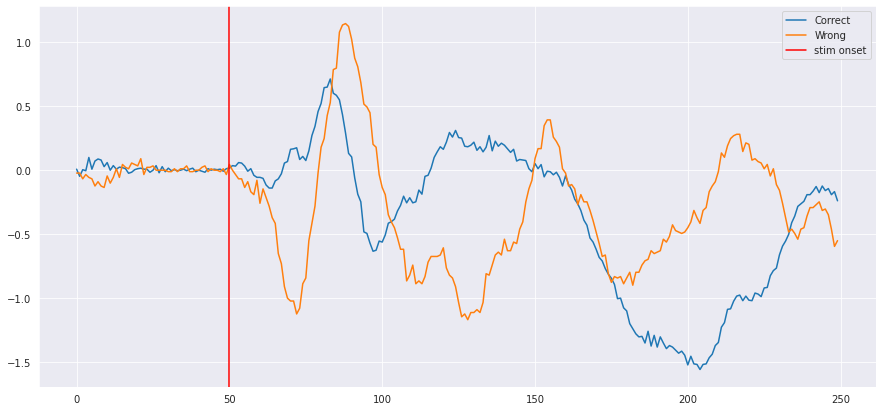

In [16]:
plt.figure(figsize=(15,7))
sns.lineplot(y = all_data[11]["wheel"][correct_trial_idx].mean(axis=0), x = np.arange(250), label="Correct")
sns.lineplot(y = all_data[11]["wheel"][wrong_trial_idx].mean(axis=0), x = np.arange(250), label="Wrong")
plt.axvline(50, color="red", label="stim onset")
plt.legend()